# Lab 3: Experimentación de hiperparámetros.



El objetivo de este laboratorio es experimentar con los conceptos teoricos vistos en clase. Se propone seguir la estructura de experimentos del documento. Como hemos visto durante el tema es muy importante vuestra conclusión después del experimento.

Para evaluar con cual nos quedamos después de cada experimento vamos a quedarnos con el que tenga mejor Accuracy en los datos de validación.

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.

## Carga de los datos

In [1]:
import cv2
import os
import numpy as np 
import keras
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:
user_profile = os.environ['USERPROFILE']
datasets_path = os.path.join(user_profile, '.keras','datasets')

Desacargar datos de entrenamiento y test

In [3]:
# # Desacargar datos de entrenamiento
# keras.utils.get_file(fname="simpsons_train.tar.gz", 
#                      origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# # Descargar datos de test
# keras.utils.get_file(fname="simpsons_test.tar.gz", 
#                      origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")

Descomprimir archivo tar

In [4]:
# import tarfile

# train_path = 'simpsons_train.tar.gz'
# test_path = 'simpsons_test.tar.gz'

# with tarfile.open(datasets_path+"\\"+train_path, 'r') as archivo:
#     archivo.extractall(datasets_path)

# with tarfile.open(datasets_path+"\\"+test_path, 'r') as archivo:
#     archivo.extractall(datasets_path)

# print("Archivo descomprimido exitosamente.")


In [5]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [6]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [7]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    # for filename in glob.glob(dirname + '/*.*'): # Linux
    for filename in glob.glob(dirname + '\\*.*'): # Windows
        # char_name = "_".join(filename.split('/')[-1].split('_')[:-1]) # Linux
        char_name = "_".join(filename.split('\\')[-1].split('_')[:-1]) # Windows
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [8]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = datasets_path+"\\simpsons"
DATASET_TEST_PATH_COLAB = datasets_path+"\\simpsons_testset"

x_train, y_train = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
x_test, y_test = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [9]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(x_train))
x_train, y_train = x_train[perm], y_train[perm]

## Herramientas de visualización de resultados

In [10]:
# Definición de funciones que permitirán la visualización de las graficas de entrenamiento
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento ' + name1, 'Validación ' + name1, 
                'Entrenamiento ' + name2, 'Validación ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()
    


## Cosas a tener en cuenta:

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe

*   Realizar un análisis de los datos a utilizar.
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.
* Un error común en Keras es no instanciar un nuevo modelo cada vez que hacemos un nuevo entrenamiento. Al hacer

      *model = Sequential()*
      *model.add(lo que sea)  # Definición del modelo*
      *model.fit()*

    Si queremos entrenar un nuevo modelo o el mismo modelo otra vez, es necesario volver a inicializar el modelo con model = Sequential().
    Si olvidamos este paso y volvemos a hacer fit(), el modelo seguirá entrenando por donde se quedó en el último fit().
* Se recomienda construir una tabla con el mejor valor del acurracy y función de validación .
* Vamos a utilizar la misma arquitectura de red neuronal para todos los experimentos, que mostramos a continuación.

In [11]:
from keras import layers
from keras import models
from keras.optimizers import Adamax, RMSprop, SGD
from keras.callbacks import EarlyStopping


# Definición y construcción del modelo 1
model = models.Sequential()
model.add(layers.Conv2D(64,(2,2), activation='relu', input_shape=(64, 64, 3), padding='same', name='Convolutiva-1'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-1'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', name='Hidden-Layer-1'))
model.add(layers.Dense(64, activation='relu', name='Hidden-Layer-2'))
model.add(layers.Dense(18, activation='softmax', name='Output-Layer'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Convolutiva-1 (Conv2D)      (None, 64, 64, 64)        832       
                                                                 
 MaxPooling-1 (MaxPooling2D  (None, 32, 32, 64)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 128)               8388736   
                                                                 
 Hidden-Layer-2 (Dense)      (None, 64)                8256      
                                                                 
 Output-Layer (Dense)        (None, 18)                1170      
                                                      

## Realización de los experimentos

### Experimento 1: Visualización y preparación del dataset

  * Visualizar algunas imagenes aleatoriamente. 
  * Comprobar el número de imagenes y formato.
  * Normalizar.
  * Cualquier otra acción que consideres oportuna que enriquezca el experimento.

Primeramente vamos a visualizar aleatoriamente algunas imagenes del dataset de training junto con su etiqueta.

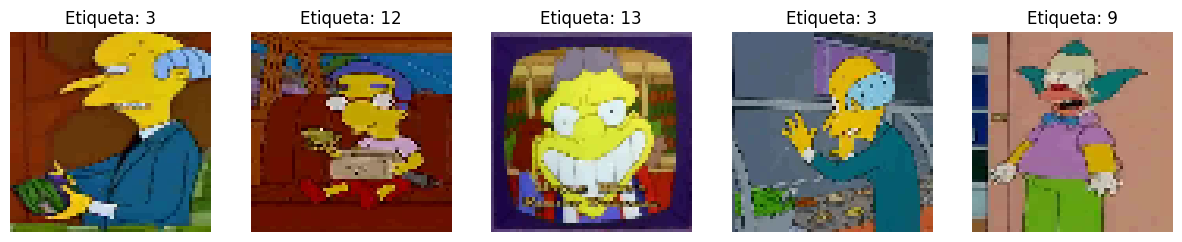

In [12]:
import matplotlib.pyplot as plt
n_images = 5
random_index = np.random.choice(len(x_train), n_images, replace=False)

plt.figure(figsize=(15, 3))

for i, indice in enumerate(random_index, start=1):
    plt.subplot(1, n_images, i)
    img = cv2.cvtColor(x_train[indice], cv2.COLOR_BGR2RGB) # Pasar a RGB
    plt.imshow(img)
    plt.title(f"Etiqueta: {y_train[indice]}")
    plt.axis('off')

plt.show()

Comprobar el número de imágenes y formato

In [13]:
print(f"Número total de imágenes en el conjunto de entrenamiento: {x_train.shape[0]}")
print(f"Dimensiones de las imágenes de entrenamiento (Alto x Ancho x Canales): {x_train.shape[1:]}")

print(f"Número total de imágenes en el conjunto de prueba: {x_test.shape[0]}")
print(f"Dimensiones de las imágenes de prueba (Alto x Ancho x Canales): {x_test.shape[1:]}")

Número total de imágenes en el conjunto de entrenamiento: 18992
Dimensiones de las imágenes de entrenamiento (Alto x Ancho x Canales): (64, 64, 3)
Número total de imágenes en el conjunto de prueba: 890
Dimensiones de las imágenes de prueba (Alto x Ancho x Canales): (64, 64, 3)


Normalización

In [14]:
x_train_norm = x_train.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0

Aumento de datos

Voy a añadir diferentes filtros a las imágenes que ya tengo para crear nuevas imágenes y así aumentar los datos de mi dataset 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


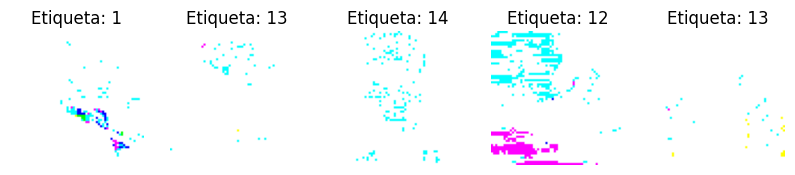

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear un generador de aumento de datos
datagen = ImageDataGenerator(
    # rotation_range=0,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    # fill_mode='nearest'
    )

# Visualizar algunas imágenes aumentadas
plt.figure(figsize=(10, 2))
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=n_images):
    for i in range(0, n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(x_batch[i])
        plt.title(f"Etiqueta: {y_batch[i]}")
        plt.axis('off')
    break
plt.show()

### Experimento 2:  Relu vs Tangente hiperbólica

Para la realización de este experimento tiene que utilizar los siguientes hiperparámetros:


*   Optimizer: SGD
*   Loss: sparse_categorical_crossentropy
*   Metrics: accuracy
*   EarlyStopping
      *   monitor=val_loss
      *   patience = 2
      *   verbose=1
*   Batch_size: 32




Construcción del modelo Relu.

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

unique_classes = np.unique(y_train)
num_classes = len(unique_classes)

# Definición del modelo
model_relu = models.Sequential()
model_relu.add(layers.Conv2D(64,(2,2), activation='relu', input_shape=(64, 64, 3), padding='same', name='Convolutiva-1'))
model_relu.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-1'))
model_relu.add(layers.Flatten())
model_relu.add(layers.Dense(128, activation='relu', name='Hidden-Layer-1'))
model_relu.add(layers.Dense(64, activation='relu', name='Hidden-Layer-2'))
model_relu.add(layers.Dense(18, activation='softmax', name='Output-Layer'))
model_relu.summary()

# Compilación del modelo
model_relu.compile(optimizer=SGD(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Configuración de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# Entrenamiento del modelo
history_relu = model_relu.fit(x_train, y_train, epochs=10, batch_size=32,
                              validation_data=(x_test, y_test),
                              callbacks=[early_stopping])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Convolutiva-1 (Conv2D)      (None, 64, 64, 64)        832       
                                                                 
 MaxPooling-1 (MaxPooling2D  (None, 32, 32, 64)        0         
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 65536)             0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 128)               8388736   
                                                                 
 Hidden-Layer-2 (Dense)      (None, 64)                8256      
                                                                 
 Output-Layer (Dense)        (None, 18)                1170      
                                                      

Construcción del modelo Tanh

In [17]:
# Definición del modelo utilizando Tanh
model_tanh = Sequential([
    Conv2D(32, (3, 3), activation='tanh', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='tanh'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model_tanh.summary()

# Compilación del modelo con Tanh
model_tanh.compile(optimizer=SGD(),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Configuración de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# Entrenamiento del modelo con Tanh
history_tanh = model_tanh.fit(x_train, y_train, epochs=10, batch_size=32,
                              validation_data=(x_test, y_test),
                              callbacks=[early_stopping])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)        

In [18]:
# Datos de accuracy y val_accuracy para ReLU
accuracy_relu = history_relu.history['accuracy']
val_accuracy_relu = history_relu.history['val_accuracy']

# Datos de accuracy y val_accuracy para Tanh
accuracy_tanh = history_tanh.history['accuracy']
val_accuracy_tanh = history_tanh.history['val_accuracy']

# Encontrar la longitud mínima de los arrays
min_length = min(len(accuracy_relu), len(val_accuracy_relu), len(accuracy_tanh), len(val_accuracy_tanh))

# Usar solo hasta la longitud mínima para asegurar que todos los arrays tienen la misma longitud
df_results = pd.DataFrame({
    'Epoch': range(1, min_length + 1),
    'Train Accuracy ReLU': accuracy_relu[:min_length],
    'Validation Accuracy ReLU': val_accuracy_relu[:min_length],
    'Train Accuracy Tanh': accuracy_tanh[:min_length],
    'Validation Accuracy Tanh': val_accuracy_tanh[:min_length]
})

In [27]:
# Para el modelo ReLU
final_accuracy_relu = history_relu.history['accuracy'][-1]  # Acceder al último valor de accuracy de entrenamiento
epochs_trained_relu = len(history_relu.history['accuracy'])  # Número de epochs completadas

# Para el modelo Tanh
final_accuracy_tanh = history_tanh.history['accuracy'][-1]  # Acceder al último valor de accuracy de entrenamiento
epochs_trained_tanh = len(history_tanh.history['accuracy'])  # Número de epochs completadas

# Crear un DataFrame con esta información
df_results = pd.DataFrame({
    'Activation Function': ['ReLU', 'Tanh'],
    'Final Training Accuracy': [final_accuracy_relu, final_accuracy_tanh],
    'Epochs Trained': [epochs_trained_relu, epochs_trained_tanh]
})

df_results.head()

,Activation Function,Final Training Accuracy,Epochs Trained
0,ReLU,0.118260,3
1,Tanh,0.663806,10


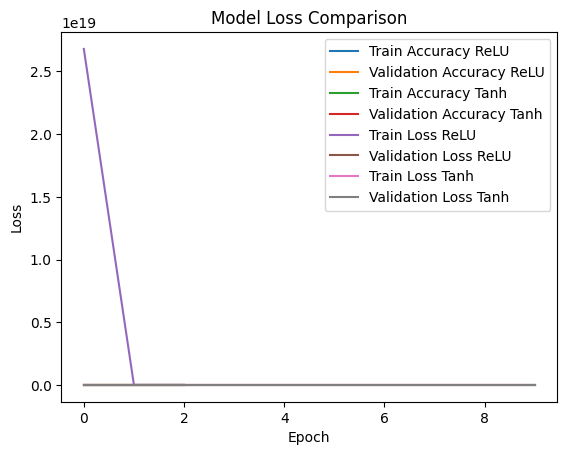

In [48]:
plot_compare_accs(history_relu, history_tanh)

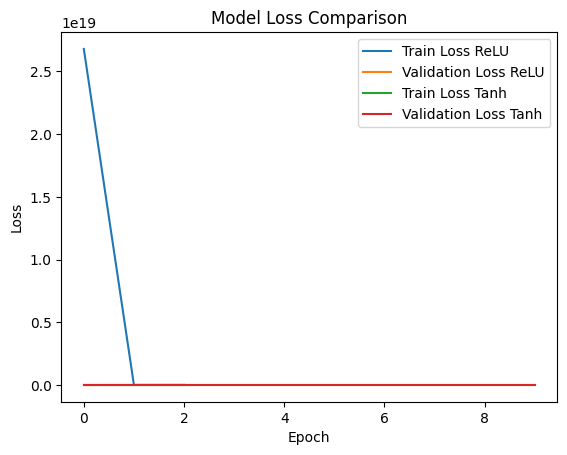

In [47]:
plot_compare_losses(history_relu, history_tanh)

### Experimento 3: Zero vs Glorot uniform



### Experimento 4 - Aleatoria Normal vs Glorot uniform  


###Experimento 5 - SGD vs RMSprop




###Experimento 6: SGD vs Adamax

Probar con learning_rate=0.002, beta_1=0.9, beta_2=0.999

###Experimento 7: Aumento batch size 512

### Experimento 8 - Aplicar BatchNormalization

### Experimento 9 - Aumentar el número de parámentros por capa

Aumentar de la siguiente manera:

*   512 a la Conv2D
*   512 a la primera Dense
*   256 a la segunda Dense



### Experimento 10 - Aplicar Dropout 0.2

###Anexos

Si os encontrais alguna anomalia mientras realizais el laboratorio, describirla en este punto, motivos del problema y solución.
